In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import cv2 # For resizing if needed, though MNIST is small


In [3]:

# --- 1. Load and Preprocess Data ---
print("Loading and preprocessing MNIST data...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape data to include channel dimension for CNN
x_train = np.expand_dims(x_train, axis=-1) # Add a channel dimension (28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)   # Add a channel dimension (28, 28, 1)

input_shape = x_train.shape[1:] # (28, 28, 1)
latent_dim = 64 # Dimension of the compressed representation


Loading and preprocessing MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:

# --- 2. Build the Autoencoder Model ---
print("Building autoencoder model...")

# Encoder
encoder_input = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(encoder_input) # 14x14x32
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)             # 7x7x64
x = Flatten()(x)
encoder_output = Dense(latent_dim, activation='relu')(x) # Latent space

encoder = Model(encoder_input, encoder_output, name="encoder")

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_input) # Reshape back to 7x7x64 for Conv2DTranspose
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=2)(x) # 14x14x64
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=2)(x) # 28x28x32
decoder_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Output image (28x28x1)

decoder = Model(decoder_input, decoder_output, name="decoder")

# Autoencoder
autoencoder_output = decoder(encoder(encoder_input))
autoencoder = Model(encoder_input, autoencoder_output, name="autoencoder")

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') # Mean Squared Error loss

# Display model summaries
encoder.summary()
decoder.summary()
autoencoder.summary()



Building autoencoder model...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       200,768 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,584 (857.75 KB)

 Trainable params: 219,584 (857.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │       203,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 64)             │       219,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       259,521 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,105 (1.83 MB)

 Trainable params: 479,105 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# --- 3. Train the Autoencoder ---
print("Training autoencoder...")
history = autoencoder.fit(x_train, x_train,
                          epochs=10, # You might need more epochs for better representation
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

# --- 4. Extract Features and Perform Clustering ---
print("Extracting features and performing K-Means clustering...")
# Get the latent space representations from the encoder
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)


Training autoencoder...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0705 - val_loss: 0.0087
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0075 - val_loss: 0.0051
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0024 - val_loss: 0.0024
Extracting features and performing K-Means clustering...
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/

In [7]:

# For segmentation, we care about clustering features of pixels.
# For MNIST, we're essentially clustering images (each image is a 'segment').
# If you had a single image and wanted to segment regions within it,
# you'd need to extract features for *each pixel* or *patch* and then cluster.
# For this example, each MNIST digit is a "segment".

# We know there are 10 digits (0-9), so we'll use n_clusters=10
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(x_train_encoded) # Fit KMeans on the training latent features

# Predict cluster labels for test set
test_cluster_labels = kmeans.predict(x_test_encoded)


Visualizing results...


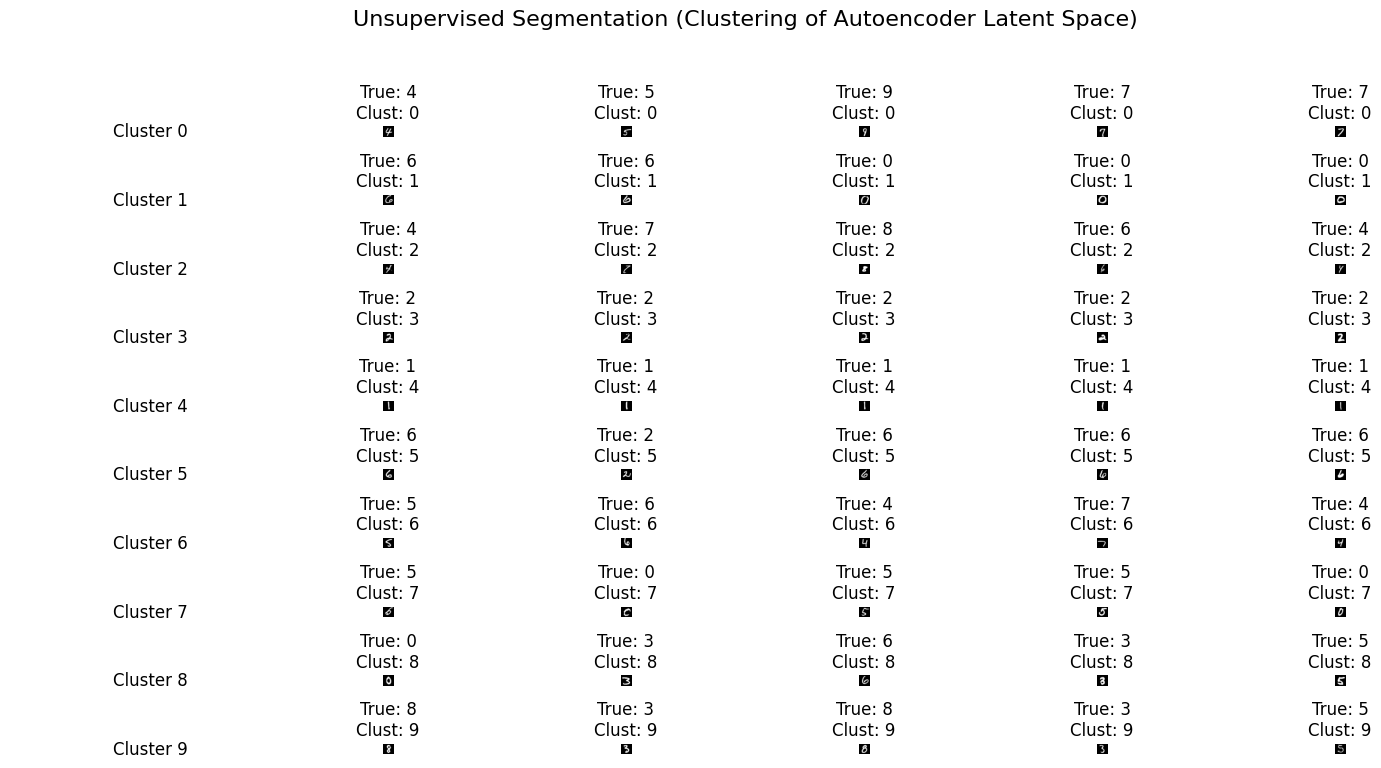

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


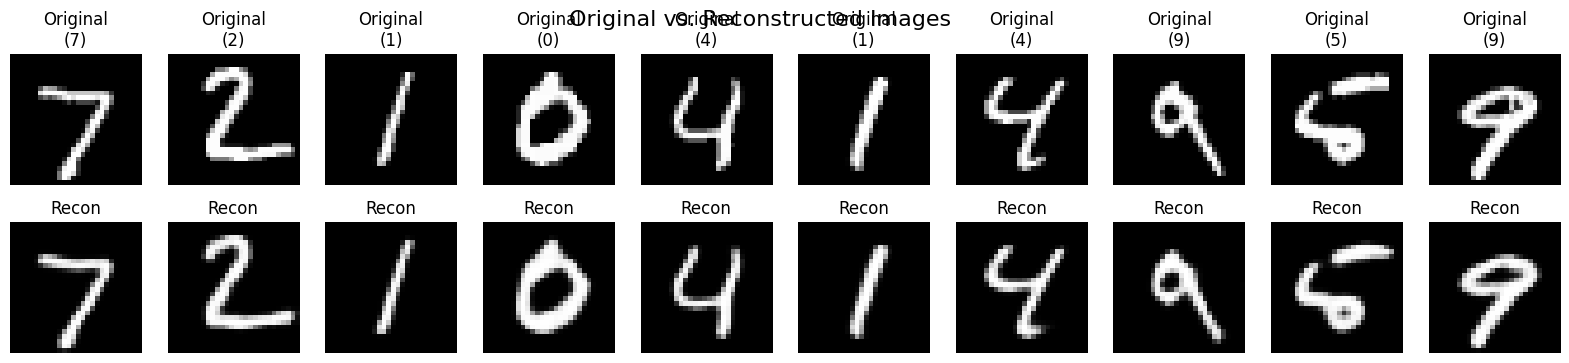

In [8]:

# --- 5. Visualize Results ---
print("Visualizing results...")

def plot_digits_in_clusters(images, true_labels, cluster_labels, n_examples=5):
    plt.figure(figsize=(15, 8))
    for i in range(n_clusters):
        # Find indices of images belonging to the current cluster
        cluster_indices = np.where(cluster_labels == i)[0]
        # Randomly select a few examples from this cluster
        np.random.shuffle(cluster_indices)
        
        for j in range(min(n_examples, len(cluster_indices))):
            idx = cluster_indices[j]
            ax = plt.subplot(n_clusters, n_examples + 1, i * (n_examples + 1) + j + 2)
            plt.imshow(images[idx].squeeze(), cmap='gray')
            plt.title(f"True: {true_labels[idx]}\nClust: {i}")
            plt.axis('off')
        
        # Add a title for the cluster row
        ax = plt.subplot(n_clusters, n_examples + 1, i * (n_examples + 1) + 1)
        ax.text(0.5, 0.5, f"Cluster {i}", horizontalalignment='center', verticalalignment='center', fontsize=12)
        plt.axis('off')

    plt.suptitle("Unsupervised Segmentation (Clustering of Autoencoder Latent Space)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_digits_in_clusters(x_test, y_test, test_cluster_labels)

# Visualize original vs reconstructed images
n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images):
    # Display original
    ax = plt.subplot(2, n_images, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"Original\n({y_test[i]})")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n_images, i + 1 + n_images)
    plt.imshow(autoencoder.predict(x_test[i:i+1]).squeeze(), cmap='gray')
    plt.title("Recon")
    plt.axis('off')
plt.suptitle("Original vs. Reconstructed Images", fontsize=16)
plt.show()


In [9]:

# --- Conceptual Extension for within-image segmentation ---
print("\n--- Conceptual note on within-image segmentation ---")
print("For segmenting regions *within* a single larger image (e.g., separating objects from background),")
print("the approach would generally involve:")
print("1. Training an autoencoder (possibly a U-Net like architecture) on a large dataset of unlabeled images.")
print("2. For a new image, extract features for each pixel/patch using the encoder.")
print("3. Reshape these pixel/patch features into a 2D array (num_pixels/patches x feature_dim).")
print("4. Apply a clustering algorithm (e.g., KMeans, GMM, Mean Shift) to these pixel/patch features.")
print("5. Reshape the resulting cluster labels back into the image dimensions to get the segmentation map.")
print("This is exactly what the 'FlowCut' paper does when it uses DINO features and then clusters them.")
print("The current MNIST example is effectively segmenting *entire images* (digits) into clusters.")


--- Conceptual note on within-image segmentation ---
For segmenting regions *within* a single larger image (e.g., separating objects from background),
the approach would generally involve:
1. Training an autoencoder (possibly a U-Net like architecture) on a large dataset of unlabeled images.
2. For a new image, extract features for each pixel/patch using the encoder.
3. Reshape these pixel/patch features into a 2D array (num_pixels/patches x feature_dim).
4. Apply a clustering algorithm (e.g., KMeans, GMM, Mean Shift) to these pixel/patch features.
5. Reshape the resulting cluster labels back into the image dimensions to get the segmentation map.
This is exactly what the 'FlowCut' paper does when it uses DINO features and then clusters them.
The current MNIST example is effectively segmenting *entire images* (digits) into clusters.
